In [236]:
run '../__init__.py'

In [133]:
APP_TOKEN = os.getenv('APP_TOKEN')
client = Socrata('data.cityofnewyork.us', APP_TOKEN)

## Get network from open street map

In [134]:
# Get shaply value from geojson
polygon = gpd.read_file('chelsea_network.geojson').to_crs(4326)['geometry'][0]

In [135]:
# Create graph from Open Street Map based on graph, Include travel time over edges
G = ox.add_edge_travel_times(ox.add_edge_speeds(ox.graph_from_polygon(polygon, network_type='drive', simplify=True)))

In [136]:
## The current method of just using osmnx to get the lines is not granular enough so we need to refilter the graph with gpd
# Creates dataframes based on nodes and edges
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# Remove edges outside of polygon
edges_gdf = edges_gdf[edges_gdf.geometry.within(polygon) == True]

# Re-create graph from filtered geodataframes
G = ox.graph_from_gdfs(nodes_gdf, edges_gdf, graph_attrs = G.graph)

In [137]:
D = ox.get_digraph(G, weight = 'travel_time')

In [138]:
# edges_gdf['osmid'] = edges_gdf['osmid'].apply(lambda x: x[0] if type(x) == list else x)
edges_gdf.reset_index(inplace=True)

## Get ATR data from OpenData NYC

In [139]:
def request_atr_series(ids):
    endpoint = "7ym2-wayt"

    query = "SELECT COUNT(*)"

    NUM_RECORDS = int(client.get(endpoint, query=query)[0]['COUNT'])
    
    query = f"""
        SELECT *
        WHERE segmentid IN ({', '.join(map(str, ids))})
        AND yr = 2019
        LIMIT {NUM_RECORDS}
    """
    
    df = pd.DataFrame.from_records(client.get(endpoint, query=query))

    df['ts'] = pd.to_datetime(df[['yr', 'm', 'd', 'hh', 'mm']]\
                 .apply(lambda row: '-'.join(row), axis=1), format='%Y-%m-%d-%H-%M')
    df = df.astype({'vol':float})   
    
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df.wktgeom, crs="ESRI:102718")).drop(columns=['wktgeom'])
    gdf = gdf.to_crs(4326)
    
    gdf['segment_direction'] = df.segmentid + '-' + df.direction
    
    return gdf

In [140]:
atrs_gdf = request_atr_series([32462, 32285,
                         32467, 32814,
                         32811, 32798, 32795,
                         32628, 32634, 32632,
                         32460, 32458, 271225,
                         32299, 32301, 32463])

In [141]:
# match our ATR data (df) to the closest street segment in the OSMNX graph (gdf_edges)
atrs_with_streets_gdf = atrs_gdf.to_crs(3857).sjoin_nearest(edges_gdf.reset_index().to_crs(3857), distance_col='dist', how='inner').drop(columns=['index_right']).to_crs(4326).rename(columns={'geometry':'atr_geometry'}).set_geometry('atr_geometry')

## Plot Dataset

In [142]:
# add back the edges geometry information
atrs_with_streets_gdf = atrs_with_streets_gdf.merge(edges_gdf[['u','v','key','geometry']], on=['u','v','key'], how='left').rename(columns={'geometry':'edge_geometry'})

In [382]:
row = atrs_with_streets_gdf.iloc[5]
def split_lines_func(row):
    i_idx = 0
    
    for i in range(0,len(row['edge_geometry'].coords)-1):
        i_coords = row['edge_geometry'].coords[i]
        j_coords = row['edge_geometry'].coords[i+1]
        bbox = sg.box(i_coords[0], i_coords[1], j_coords[0], j_coords[1])
        if bbox.contains(row['atr_geometry']):
            i_idx = i
            break
    
    coords_lst = [k for k in row['edge_geometry'].coords]
    
    
    coords_lst.insert(i_idx+1, tuple(row['atr_geometry'].coords)[0])
    
    linestring = sg.LineString(coords_lst)
    
    return split(linestring, row['atr_geometry'])

atrs_with_streets_gdf['split_edges'] = atrs_with_streets_gdf.apply(lambda x: split_lines_func(x),axis = 1) 

In [385]:
atrs_with_streets_gdf['split_edges'] = atrs_with_streets_gdf['split_edges'].apply(lambda x: [g for g in x.geoms])
atrs_with_streets_gdf = atrs_with_streets_gdf.explode(column='split_edges').set_geometry('split_edges')

<Axes: >

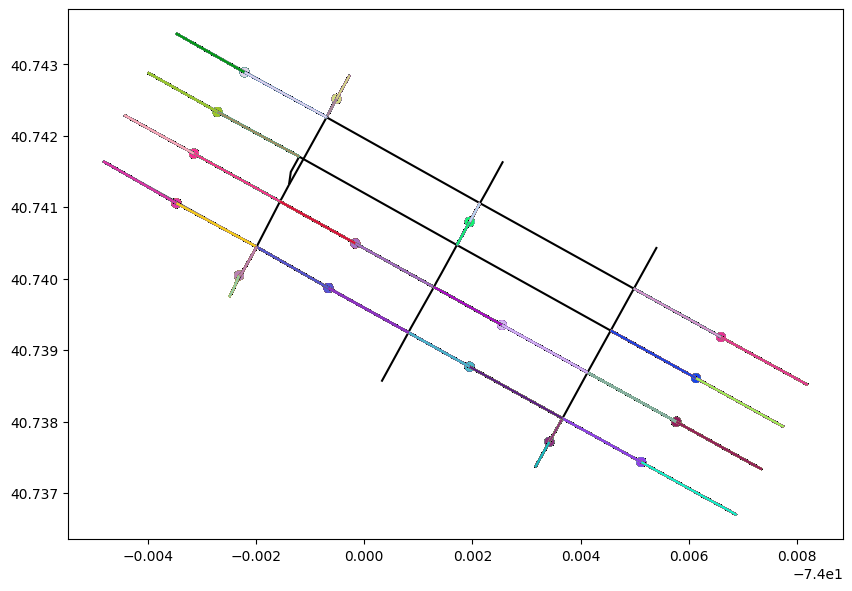

In [394]:
fig, ax = plt.subplots(figsize=(10,10))

color_lst = [(random.random(), random.random(), random.random()) for i in range(len(atrs_with_streets_gdf))]
edges_gdf.plot(ax = ax, color = 'black')
atrs_with_streets_gdf.set_geometry('split_edges').plot(ax = ax,color=color_lst)
atrs_with_streets_gdf.set_geometry('atr_geometry').plot(ax = ax,color=color_lst)

